### Bibliotecas

In [217]:
pip install --upgrade mplfinance

Note: you may need to restart the kernel to use updated packages.


In [218]:
import pandas as pd
import numpy as np
from binance.client import Client
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf

In [219]:
credentials = service_account.Credentials.from_service_account_file("cloud.json", 
                                                                    scopes = ["https://www.googleapis.com/auth/cloud-platform", 
                                                                              "https://www.googleapis.com/auth/drive"])

### Conexão com a API da Binance

In [220]:
api_key = os.getenv(key='BINANCE_API-KEY')
api_secret = os.getenv(key='BINANCE_SECRET_KEY')

In [221]:
Client = Client(api_key, api_secret)

### Extraindo dados históricos do Bitcoin

In [222]:
def binanceDataFrame(symbol): 
        arr = np.array(Client.get_historical_klines(symbol= symbol, 
                      interval = Client.KLINE_INTERVAL_1DAY,
                      start_str =  '2021-09-01' #datetime.today().strftime('%Y-%m-%d')
                                            )
                )  
        df = pd.DataFrame(arr, dtype=float, columns = (
                                                'Open_Time'
                                               ,'Open'
                                               ,'High'
                                               ,'Low'
                                               ,'Close'
                                               ,'Volume'
                                               ,'Close_Time'
                                               ,'Quote_asset_volume'
                                               ,'Number_Of_Trades'
                                               ,'Taker_Buy_Base_Asset'
                                               ,'Taker_Buy_Quote_Asset'
                                               ,'Ignore'
                                               )
                 )
        df['Open_Time'] = pd.to_datetime(df['Open_Time'], unit= 'ms').dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo')
        df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit= 'ms').dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo')
        df['Coin'] = symbol
        df = df[[
                'Coin'
               ,'Open_Time'
               ,'Open'
               ,'High'
               ,'Low'
               ,'Close'
               ,'Volume'
               ,'Close_Time'
               ,'Number_Of_Trades']]

        return df

In [223]:
btc = binanceDataFrame(symbol= 'BTCUSDT')

In [224]:
eth = binanceDataFrame(symbol= 'ETHUSDT')

### Criação de bandas de Bollinger

In [225]:
# Média movel das última 40h
btc['MM_20'] = btc['Close'].shift(1).rolling(20).mean()
eth['MM_20'] = eth['Close'].shift(1).rolling(20).mean()

In [226]:
# Desvio Padrão das última 40h
btc['DP_20'] = btc['Close'].shift(1).rolling(20).std()
eth['DP_20'] = eth['Close'].shift(1).rolling(20).std()

In [227]:
# Banda Inferior
btc['Banda_Inferior'] = btc['MM_20'] - btc['DP_20']*2
eth['Banda_Inferior'] = eth['MM_20'] - eth['DP_20']*2

In [228]:
# Banda Superior
btc['Banda_Superior'] = btc['MM_20'] + btc['DP_20']*2
eth['Banda_Superior'] = eth['MM_20'] + eth['DP_20']*2

In [229]:
Cripto = pd.concat([btc,eth])

### Load para o BigQuery

In [230]:
Cripto.to_gbq( project_id = 'learning-cloud-328108'
           ,credentials = credentials
           ,destination_table= 'BinanceCriptomoedas.Cripto'
           ,if_exists='replace')

### Plot do gráfico

In [231]:
Cripto = Cripto.loc[Cripto['Coin'] == 'BTCUSDT']

In [232]:
Cripto = Cripto.rename(columns={'Open_Time': 'Date'})

In [233]:
Cripto = Cripto = Cripto[['Date'
               ,'Open'
               ,'High'
               ,'Low'
               ,'Close'
               ,'Volume'
               ]]

In [234]:
Cripto = pd.DataFrame.from_dict(Cripto) 
Cripto.set_index('Date', inplace=True)


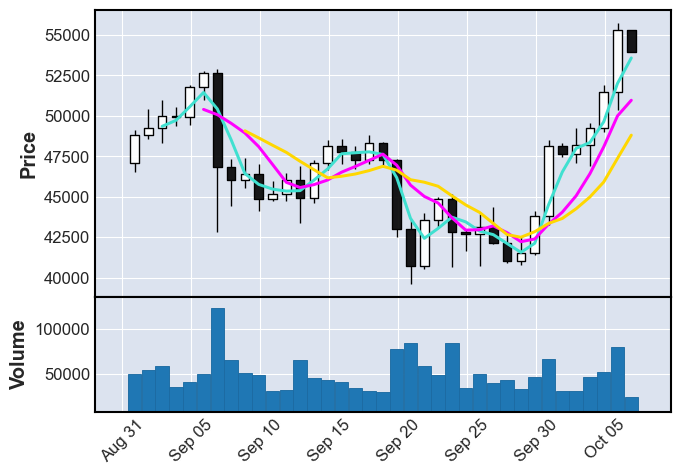

In [235]:
mpf.plot(Cripto,type='candle',mav=(3,6,9),volume=True,show_nontrading=True)